# Aulas 06~14 - Classificação

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

- [Árvores de decisão](#Árvores-de-decisão)
  - [Entropia e ganho de informação](#Entropia-e-ganho-de-informação)
  - [Exemplos de entropia, informação média e ganho de informação](#Exemplos-de-entropia,-informação-média-e-ganho-de-informação)
    - [Usando entropia para encontrar o primeiro atributo da árvore para o conjunto `tennis`](#Usando-entropia-para-encontrar-o-primeiro-atributo-da-árvore-para-o-conjunto-tennis)
      - [Informação do espaço original](#Informação-do-espaço-original)
      - [Passo-a-passo do atributo `aparência`](#Passo-a-passo-do-atributo-aparência)
      - [Ganho de informação dos atributos restantes](#Ganho-de-informação-dos-atributos-restantes)
- [Máquinas de vetores de suporte (SVM)](#Máquinas-de-vetores-de-suporte-(SVM))

# Árvores de decisão

## Entropia e ganho de informação

A função `info` calcula a quantidade média de informação de uma variável aleatória. Ela deve receber números inteiros que refletem a proporção dos eventos. Por exemplo, uma moeda honesta pode resultar em "cara" ou "coroa" com igual probabilidade, portanto deve ser chamada como `info([1,1])`, `info([2,2])` etc. Já para uma moeda viciada em que um das faces pode sair com frequência duas vezes maior que a outra, a função deve ser chamada como `info([1,2])`, `info([2,4])` etc.

Exemplos:

- Moeda honesta: `info([1,1])` ou `info([2,2])` -- ambos os eventos têm igual frequência
- Moeda viciada: `info([1,2])` -- um dos eventos ocorre com probabilidade $p_1=\frac{1}{3}$ e o outro com probabilidade $p_2=\frac{2}{3}$
- Dado honesto: `info([1,1,1,1,1,1])` ou `info([1]*6)` -- todos os lados têm igual probabilidade, isto é, $p_i=\frac{1}{6}$

In [2]:
def info(freq):
    freq = [x for x in freq if x != 0] # remove zeros
    if len(freq) == 0:                 # [0], [0,0], [0,0,0] etc têm informação 0
        return 0
    
    freq = np.array(freq, dtype=np.float)
    total = freq.sum()
    
    fracoes = freq/total
    logs = np.log2(fracoes)
    
    somatorio = (fracoes * logs).sum()
    
    return -somatorio

A função `infomedia` calcula a quantidade média de informação de um particionamento. Cada sub-espaço é representado por uma variável aleatória que indica a probabilidade de cada classe.

Exemplos:

- Primeiro corte do **slide 84**: `infomedia([[0, 9], [6, 5]])` --> o **atributo `x`** divide o espaço original em dois; no sub-espaço esquerdo há 0 exemplos da classe `a` e 9 da classe `b`; no sub-espaço direito há 6 exemplos da classe `a` e 5 exemplos da classe `b`;
- Segundo corte do **slide 84**: `infomedia([[5, 0], [1, 5]])` --> o **atributo `y`** faz uma nova divisão do espaço; o sub-espaço resultante tem na parte superior apenas exemplos da classe `a` e na parte inferior 1 exemplo da classe `a` entre 5 da classe `b`;
- Particionamento feito pelo atributo `temperatura` no **slide 77**: `infomedia([[2,2], [4,2], [3,1]])`.

In [3]:
def infomedia(bins):
    contagem = 0
    for b in bins:
        contagem += sum(b)
        
    info_media = 0
    for b in bins:
        info_media += sum(b)/contagem * info(b)
    
    return info_media

## Exemplos de entropia, informação média e ganho de informação

**Slide 95**: entropia de uma moeda honesta com $p(H) = 0{,}5$ e $p(T) = 0{,}5$.

In [4]:
info([1,1])

1.0

**Slide 96:** Entropia de um dado honesto de quatro faces:

In [5]:
info([1,1,1,1])

2.0

**Slide 97:** Entropia de uma moeda viciada que sempre retorna "cara" ou "coroa":

In [6]:
info([1])

-0.0

(*observação:* o Python pode retornar o resultado **-0.0**. Isso não é um erro. O padrão IEEE 754 prevê um zero positivo e um zero negativo)

**Slide 100:** entropia do dado viciado de 4 faces

In [7]:
info([2, 1, 1, 0])

1.5

### Usando entropia para encontrar o primeiro atributo da árvore para o conjunto `tennis`

Os cálculos a seguir referem-se aos slides 115~122.

#### Informação do espaço original

Entropia do espaço de classes original do nosso conjunto de dados `tennis`, contendo 9 exemplos da classe `sim` e 5 exemplos da classe `não`:

In [8]:
info([9,5])

0.9402859586706309

#### Passo-a-passo do atributo `aparência`

Entropia do subespaço `aparência = ensolarado`.

$$\text{info}([2,3]) = -\frac{2}{5}\log\left(\frac{2}{5}\right) - \frac{3}{5}\log\left(\frac{3}{5}\right)$$

In [9]:
info([2,3])

0.9709505944546686

Entropia do subespaço `aparência = nublado`.

$$\text{info}([4,0]) = -\frac{4}{4}\log\left(\frac{4}{4}\right) - \frac{0}{4}\log\left(\frac{0}{4}\right)$$

ou simplesmente

$$\text{info}([4,0]) = -\log1 - 0\cdot\log0$$

In [10]:
info([4,0])

-0.0

Entropia do subespaço `aparência = chuvoso`.

$$\text{info}([3,2]) = \text{info}([2,3])$$

In [11]:
info([3,2])

0.9709505944546686

Entropia média do particionamento.

$$\text{info}([2,3],[4,0],[3,2]) = \frac{5}{14}\cdot\text{info}([2,3])~~+~~\frac{4}{14}\cdot\text{info}([4,0])~~+~~\frac{5}{14}\cdot\text{info}([3,2])$$

In [12]:
infomedia([[2,3],[4,0],[3,2]])

0.6935361388961918

Ganho de informação para o atributo **aparência**:

$$GI(\text{aparência}) = \text{info}([9,5]) - \text{info}([2,3],[4,0],[3,2])$$

In [13]:
info([9,5]) - infomedia([[2,3],[4,0],[3,2]])

0.2467498197744391

#### Ganho de informação dos atributos restantes

Ganho de informação para o atributo **temperatura**.

$$GI(\text{temperatura}) = \text{info}([9,5]) - \text{info}([2,2],[4,2],[3,1])$$

In [14]:
info([9,5]) - infomedia([[2,2],[4,2],[3,1]])

0.029222565658954647

Ganho de informação para o atributo **umidade**.

$$GI(\text{umidade}) = \text{info}([9,5]) - \text{info}([6,1],[3,4])$$

In [15]:
info([9,5]) - infomedia([[6,1],[3,4]])

0.15183550136234136

Ganho de informação para o atributo **vento**.

$$GI(\text{temperatura}) = \text{info}([9,5]) - \text{info}([6,2],[3,3])$$

In [29]:
info([9,5]) - infomedia([[6,2],[3,3]])

0.04812703040826927

# Máquinas de vetores de suporte (SVM)

Base de dados `iris`:

In [31]:
iris = sns.load_dataset('iris')

In [32]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


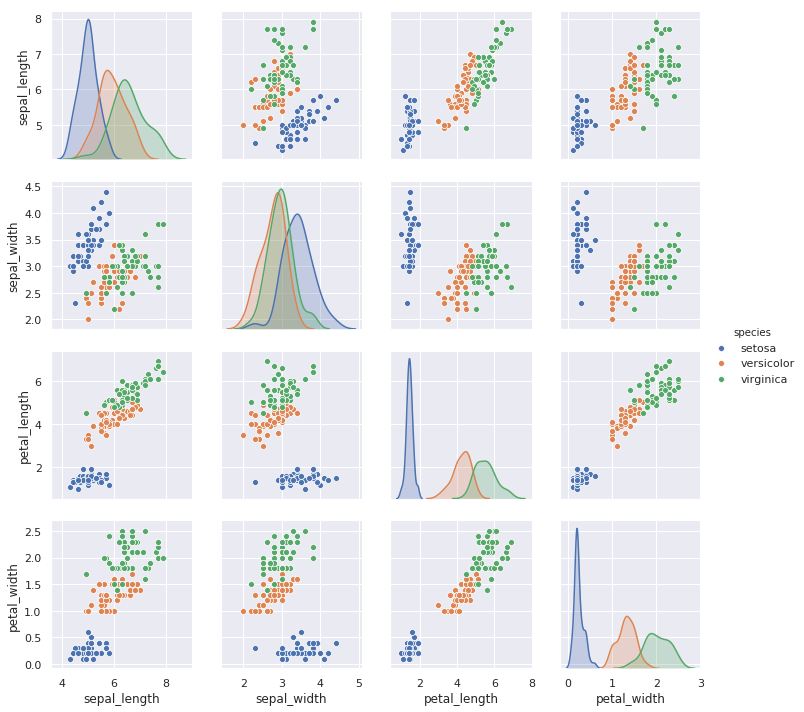

In [33]:
sns.pairplot(iris, hue='species');

Separação dos dados em características e classes:

In [34]:
X = iris.iloc[:, :-1]
y = iris.iloc[:, -1]

Treinamento do modelo:

In [35]:
from sklearn.svm import SVC
modelo = SVC(C=1,  kernel='poly', degree=2)
modelo.fit(X, y)

/usr/lib/python3/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Vetores de suporte:

In [36]:
modelo.support_vectors_

array([[5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [4.5, 2.3, 1.3, 0.3],
       [5.1, 3.8, 1.9, 0.4],
       [6.2, 2.2, 4.5, 1.5],
       [5.9, 3.2, 4.8, 1.8],
       [6.3, 2.5, 4.9, 1.5],
       [6.7, 3. , 5. , 1.7],
       [6. , 2.7, 5.1, 1.6],
       [5.4, 3. , 4.5, 1.5],
       [5.1, 2.5, 3. , 1.1],
       [4.9, 2.5, 4.5, 1.7],
       [6. , 2.2, 5. , 1.5],
       [6.3, 2.7, 4.9, 1.8],
       [6.2, 2.8, 4.8, 1.8],
       [6.1, 3. , 4.9, 1.8],
       [6.3, 2.8, 5.1, 1.5],
       [6. , 3. , 4.8, 1.8]])